In [1]:
import os
import anndata as ad
import umap
import scipy as sip
from scipy import sparse
from sklearn import preprocessing
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import v_measure_score
from snf import compute, metrics
import matplotlib.pyplot as plt
from PyComplexHeatmap import *
from collections import Counter
import math

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [136]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

original = os.path.join(input, "original")
complementary = os.path.join(input, "complementary")

pb = os.path.join(output, "pb")
shared = os.path.join(output, "shared")
shared_74 = os.path.join(output, "shared_74")

In [137]:
with open(os.path.join(shared_74, "shared_patients_across_networks_74.pickle"), "rb") as f:
    patients_74 = pickle.load(f) 
with open(os.path.join(shared_74, "graphs_with_74_nodes.pickle"), "rb") as f:
    graphs_74 = pickle.load(f) 
with open(os.path.join(shared_74, "module_data.pickle"), "rb") as f:
    module_data = pickle.load(f) 
with open(os.path.join(shared_74, "noise_graphs_with_74_nodes.pickle"), "rb") as f:
    noise_74 = pickle.load(f) 

with open(os.path.join(complementary, "noise_name_to_id.pickle"), "rb") as f:
    noise_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "noise_id_to_name.pickle"), "rb") as f:
    noise_id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "name_to_id.pickle"), "rb") as f:
    name_to_id = pickle.load(f) 

with open(os.path.join(complementary, "module_name_to_id.pickle"), "rb") as f:
    module_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "id_to_module_name.pickle"), "rb") as f:
    id_to_module_name = pickle.load(f) 

with open(os.path.join(shared, 'shared_patient_75_to_all_diseases.pickle'), 'rb') as f:
    patient_to_disease_evolution = pickle.load(f)
with open(os.path.join(shared, 'patient_to_assigned_disease.pickle'), 'rb') as f:
    patient_to_disease = pickle.load(f)
with open(os.path.join(shared, 'patient_to_disease_group.pickle'), 'rb') as f:
    patient_to_disease_group = pickle.load(f)
with open(os.path.join(shared, 'disease_group_to_patient.pickle'), 'rb') as f:
    disease_group_to_patient = pickle.load(f)
with open(os.path.join(shared, 'assigned_disease_to_patient.pickle'), 'rb') as f:
    patient_to_disease = pickle.load(f)


In [138]:
diseases = list(graphs_74["G0"].obs.Disease.unique())
disease_groups = list(graphs_74["G0"].obs.DiseaseGroup.unique())

In [139]:
# For every modality, extract the set of graphs belonging to it
citeRNA_g_with_74 = {}
bulkRNA_g_with_74 = {}
luminex_g_with_74 = {}
cytof_g_with_74 = {}
adt_g_with_74 = {}
facs_g_with_74 = {}
for id, g in graphs_74.items():
    modality = g.uns["modality"]
    if modality == "citeRNA":
        citeRNA_g_with_74[id] = g
    elif modality == "bulkRNA":
        bulkRNA_g_with_74[id] = g
    elif modality == "cytof":
        cytof_g_with_74[id] = g
    elif modality == "luminex":
        luminex_g_with_74[id] = g
    elif modality == "facs":
        facs_g_with_74[id] = g
    elif modality == "adt":
        adt_g_with_74[id] = g

In [141]:
ground_truth_dg = {}
ground_truth_d = {}
for p in graphs_74["G0"].obs_names:
    dg = graphs_74["G0"][p].obs.DiseaseGroup[0]
    d = graphs_74["G0"][p].obs.Disease[0]

    if dg == "Healthy":
        ground_truth_dg[p] = 0
    elif dg == "Sepsis":
        ground_truth_dg[p] = 1
    elif dg == "COVID":
        ground_truth_dg[p] = 2

    if d == "COVID_HCW_MILD":
        ground_truth_d[p] = 0
    elif d == "HV":
        ground_truth_d[p] = 1
    elif d == "Sepsis":
        ground_truth_d[p] = 2
    elif d == "COVID_MILD":
        ground_truth_d[p] = 3
    elif d == "COVID_SEV":
        ground_truth_d[p] = 4
    elif d == "COVID_CRIT":
        ground_truth_d[p] = 5

In [142]:
interesting_patients = [
"S00027-Ja003",
"S00033-Ja003",
"S00033-Ja005",
"S00068-Ja005",
"S00095-Ja005",
"S00065-Ja003",
"S00005-Ja005",
"S00040-Ja005",
"S00119-Ja003",
"S00020-Ja003"]
interesting_patients = set([p.split("-")[0] for p in interesting_patients]) # Extract ids, remove duplicates
interesting_patients = list(set(patients_74).intersection(interesting_patients))


healthy_patients = [p for p in list(graphs_74["G0"].obs_names) if graphs_74["G0"][p].obs.Disease[0] == "HV"]


palette = ig.RainbowPalette(n=7)
disease_color_map = {diseases[i]:palette[i] for i in range(6)}
palette = ig.RainbowPalette(n=3)
disease_group_color_map = {disease_groups[i]:palette[i] for i in range(3)}

In [143]:
panelize_reward_d = []
panelize_reward_dg = []

for i in patients_74:
    panelize_reward_d_ij = []
    panelize_reward_dg_ij = []

    d1 = graphs_74["G0"][i].obs.Disease[0]
    dg1 = graphs_74["G0"][i].obs.DiseaseGroup[0]

    for j in patients_74:
        d2 = graphs_74["G0"][j].obs.Disease[0]
        dg2 = graphs_74["G0"][j].obs.DiseaseGroup[0]

        if d1 == d2:
            panelize_reward_d_ij.append(1)
        else:
            panelize_reward_d_ij.append(-1)
        """elif dg1 == dg2:
            p_d_ij.append(0.5)
        elif d1 == "HV" or d2 == "HV":
            p_d_ij.append(-1)
        else:
            p_d_ij.append(-0.5)"""

        if dg1 == dg2:
            panelize_reward_dg_ij.append(1)
        elif dg1 == "Healthy" or dg2 == "Healthy":
            panelize_reward_dg_ij.append(-2)
        else:
            panelize_reward_dg_ij.append(-1)

    panelize_reward_d.append(panelize_reward_d_ij)
    panelize_reward_dg.append(panelize_reward_dg_ij)


for i in range(len(panelize_reward_dg)):
    panelize_reward_d[i][i] = 0
    panelize_reward_dg[i][i] = 0

panelize_reward_d = np.array(panelize_reward_d, dtype="float64")
panelize_reward_dg = np.array(panelize_reward_dg, dtype="float64")

In [144]:
optimal_graph = []
for i, dg1 in enumerate(list(graphs_74["G0"].obs.DiseaseGroup)):
    neighbors_of_i = []
    for j, dg2 in enumerate(list(graphs_74["G0"].obs.DiseaseGroup)):
        if i == j or dg1 != dg2:
            neighbors_of_i.append(0)
        else:
            neighbors_of_i.append(1)
    optimal_graph.append(neighbors_of_i)
    
optimal_graph = np.array(optimal_graph, dtype = "float64")
print(optimal_graph)

optimal_rw_score = 74

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [145]:
modality_frequency_weights = {"citeRNA": 1/209, "bulkRNA": 1/12, "adt": 1/11, "facs": 1, "luminex": 1, "cytof": 1/12 }
modality_frequency_weights  = {id: modality_frequency_weights[g.uns["modality"]] for id, g in graphs_74.items()}
weighted_avg_weights = {id: 1/len(graphs_74)  for id, g in graphs_74.items()}

In [146]:
id_to_feature_matrices = {} # standard normalized
for id, g in graphs_74.items():
    id_to_feature_matrices[id] = g.X.copy()

with open(os.path.join(shared_74, "id_to_feature_matrices.pickle"), "wb") as f:
    pickle.dump(id_to_feature_matrices, f) 


id_to_modality = {id:ad_obj.uns["modality"] for id, ad_obj in  graphs_74.items()}

with open(os.path.join(shared_74, "id_to_modality.pickle"), "wb") as f:
    pickle.dump(id_to_modality, f) 

## Functions

In [147]:
def make_transition_matrix(fused_network):
    tm = []
    for i, row in enumerate(fused_network):
        tm.append(row/ sum(row))
    return tm

def random_walker_objective(transition_matrix):
    d_score = (transition_matrix * panelize_reward_d).sum()
    dg_score = (transition_matrix * panelize_reward_dg).sum()
    #score = 0.5 * d_score + 0.5 * dg_score
    score =  dg_score
    return d_score, dg_score, score

def adjust_weights(psns, scale_weights = modality_frequency_weights):
    adjusted_weights = {}
    for id, psn in psns.items():
        adjusted_weights[id] = psn * modality_frequency_weights[id]
    return adjusted_weights

In [149]:
def knn(g, k, metric): # g is an AnnData Object
    scp.pp.neighbors(g, n_neighbors = k, use_rep='X', metric =  metric) 
    return np.array(sparse.csr_matrix.todense(g.obsp["connectivities"]), dtype = "float64") # Returns a matrix

def aff(g, metric, k, mu ): # g is a list of matrices 
    return compute.make_affinity(g, metric=metric, K=k, mu=mu, normalize = False)  # Returns a list of matrices

# Optimization

## Optimizing PSNs

In [33]:
setup_knn = {}
n = 250
ks = np.random.choice([4,5,6,7], replace=True, size=n)
metrics = np.random.choice(["cosine", "euclidean", "sqeuclidean", "correlation", "seuclidean", "minkowski", "mahalanobis", "chebyshev", "canberra"], replace=True, size=n)
methods = np.random.choice(["umap", "gauss"], replace=True, size=n)
for i in range(n):
    print(str(i), "/", str(n))
    try:
        k = ks[i]
        metric = metrics[i]
        method = methods[i]
        graphs = {}
        fused = None
        
        for id, g in graphs_74.items():
            weight = modality_frequency_weights[id]
            graphs[id] = knn(g, k, metric, method)

            if fused is None:
                fused = weight * graphs[id]
            else:
                fused = weight * graphs[id] + fused
            
        
        transition = make_transition_matrix(fused)
        score = random_walker_objective(transition)[2]
    
        print("success")
        setup_knn[score] = {"k":k, "metric": metric, "method": method}

    except np.linalg.LinAlgError:
        print(i, "fail")
        continue
    except BaseException:
        print(i, "fail")
        continue

0 / 250
success
1 / 250
success
2 / 250
success
3 / 250
success
4 / 250
success
5 / 250
success
6 / 250
6 fail
7 / 250
success
8 / 250
8 fail
9 / 250
success
10 / 250
10 fail
11 / 250
success
12 / 250
success
13 / 250
success
14 / 250
success
15 / 250
success
16 / 250
success
17 / 250
success
18 / 250
success
19 / 250
success
20 / 250
success
21 / 250
success
22 / 250
success
23 / 250
success
24 / 250
24 fail
25 / 250
success
26 / 250
success
27 / 250
success
28 / 250
success
29 / 250
success
30 / 250
success
31 / 250
success
32 / 250
success
33 / 250
success
34 / 250
34 fail
35 / 250
success
36 / 250
36 fail
37 / 250
37 fail
38 / 250
success
39 / 250
success
40 / 250
success
41 / 250
41 fail
42 / 250
42 fail
43 / 250
success
44 / 250
success
45 / 250
success
46 / 250
success
47 / 250
success
48 / 250
success
49 / 250
success
50 / 250
success
51 / 250
51 fail
52 / 250
success
53 / 250
success
54 / 250
54 fail
55 / 250
success
56 / 250
success
57 / 250
success
58 / 250
success
59 / 250


In [98]:
setup_knn = {k: v for k, v in sorted(setup_knn.items(), key=lambda item: item[0])} # sort according to scores
best_knn = setup_knn[list(setup_knn.keys())[-1]]
print(best_knn)

optimal_psns = {}
        
for id, g in graphs_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    optimal_psns[id] = graph
    g.uns["PSN-knn"] = graph
    #graphs_with_74_nodes[i] = g

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: 

In [163]:
noise_psns = {}
for id, g in noise_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    noise_psns[id] = graph
    g.uns["PSN-knn"] = graph

In [17]:
setup_kernel = {}
n = 450
ks = np.random.choice([4,5,6,7], replace=True, size=n)
metrics = np.random.choice(["cosine", "euclidean", "sqeuclidean", "correlation", "seuclidean", "minkowski", "mahalanobis", "chebyshev", "canberra"], replace=True, size=n)
mus = np.random.choice([0.3, 0.4, 0.5, 0.6, 0.7, 0.8], replace=True, size=n)
for i in range(n):
    print(str(i), "/", str(n))
    try:
        k = ks[i]
        metric = metrics[i]
        mu = mus[i] 
        
        graphs = aff(list(id_to_feature_matrices.values()), metric, k, mu)
        fused = compute.snf(graphs, K=k, t = 60)

        transition = make_transition_matrix(fused)
        score = random_walker_objective(transition)[2]

        print("success")
        setup_kernel[score] = {"k":k, "metric": metric, "mu": mu}
        
    except ValueError:
        print(i, "fail")
        continue

0 / 450
success
1 / 450
success
2 / 450
success
3 / 450
3 fail
4 / 450
success
5 / 450
success
6 / 450
success
7 / 450
success
8 / 450
success
9 / 450
success
10 / 450
success
11 / 450
success
12 / 450
12 fail
13 / 450
13 fail
14 / 450
success
15 / 450
success
16 / 450
success
17 / 450
success
18 / 450
success
19 / 450
success
20 / 450
success
21 / 450
21 fail
22 / 450
success
23 / 450
success
24 / 450
24 fail
25 / 450
success
26 / 450
success
27 / 450
success
28 / 450
28 fail
29 / 450
success
30 / 450
success
31 / 450
success
32 / 450
success
33 / 450
33 fail
34 / 450
34 fail
35 / 450
success
36 / 450
success
37 / 450
success
38 / 450
38 fail
39 / 450
success
40 / 450
success
41 / 450
success
42 / 450
success
43 / 450
success
44 / 450
success
45 / 450
success
46 / 450
success
47 / 450
success
48 / 450
success
49 / 450
success
50 / 450
success
51 / 450
success
52 / 450
52 fail
53 / 450
53 fail
54 / 450
success
55 / 450
success
56 / 450
success
57 / 450
success
58 / 450
success
59 / 450

In [101]:
setup_kernel = {k: v for k, v in sorted(setup_kernel.items(), key=lambda item: item[0])} # sort according to scores
best_kernel = setup_kernel[list(setup_kernel.keys())[-1]]
print(best_kernel)

optimal_affs = {}
graphs = compute.make_affinity(list(id_to_feature_matrices.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(id_to_feature_matrices.keys()):
    optimal_affs[id] = graphs[i]
    graphs_74[id].uns["PSN-kernel"] = graphs[i]

In [162]:
noise_affs = {}
graphs_noise = [g.X for g in noise_74.values()]
graphs_noise = compute.make_affinity(graphs_noise, metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(noise_74.keys()):
    noise_affs[id] = graphs_noise[i]
    noise_74[id].uns["PSN-kernel"] = graphs_noise[i]

In [197]:
correlations = {}
for id, ad_obj in graphs_74.items():
    correlations[id] = ad_obj.to_df().T.corr().to_numpy()

noise_correlations = {}
for id, ad_obj in noise_74.items():
    noise_correlations[id] = ad_obj.to_df().T.corr().to_numpy()

In [198]:
for id in noise_affs.keys():
    np.random.shuffle(noise_affs[id])
    np.random.shuffle(noise_psns[id])

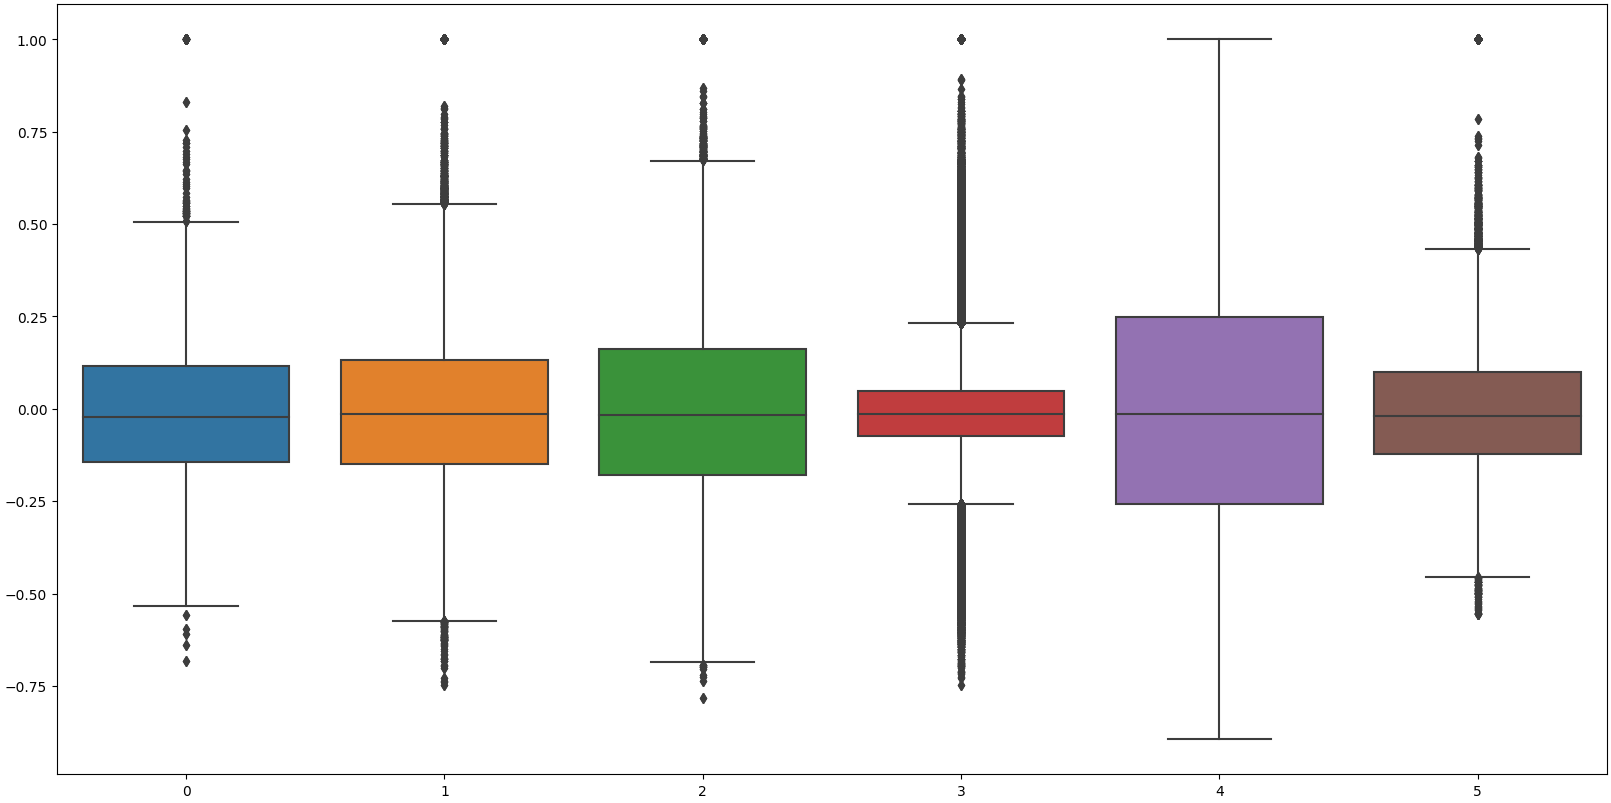

In [199]:
corr_info_per_modality = {m: [] for m in set(id_to_modality.values())}
for id, c in correlations.items():
    m = id_to_modality[id]
    corr_info_per_modality[m] =corr_info_per_modality[m] + (list(c.flatten()))

fig, ax = plt.subplots(figsize=(20,10))
ax = sb.boxplot(list(corr_info_per_modality.values()), ax = ax )


correlations_original = correlations.copy()
for id, c in correlations.items():
    zeros = np.argwhere(c < 0)
    for z_loc in zeros:
        c[z_loc[0], z_loc[1]] = 0
    correlations[id] = c


# removing self-loops
for id in list(optimal_psns.keys()):
    for i in range(len(patients_74)):
        optimal_psns[id][i][i] = 0
        optimal_affs[id][i][i] = 0 
        correlations[id][i][i] = 0 
for id in list(noise_correlations.keys()):
    for i in range(len(patients_74)):
        noise_correlations[id][i][i] = 0
        noise_affs[id][i][i] = 0
        noise_psns[id][i][i] = 0

In [200]:
with open(os.path.join(shared_74, 'correlations.pickle'), 'wb') as f:
    pickle.dump(correlations, f)
with open(os.path.join(shared_74, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_psns, f)
with open(os.path.join(shared_74, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_affs, f)


with open(os.path.join(shared_74, 'noise_correlations.pickle'), 'wb') as f:
    pickle.dump(noise_correlations, f)
with open(os.path.join(shared_74, 'noise_knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(noise_psns, f)
with open(os.path.join(shared_74, 'noise_kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(noise_affs, f)

In [43]:
with open(os.path.join(shared_74, 'correlations.pickle'), 'rb') as f:
    correlations = pickle.load(f)
with open(os.path.join(shared_74, 'knn_PSNs.pickle'), 'rb') as f:
    optimal_psns = pickle.load(f)
with open(os.path.join(shared_74, 'kernel_PSNs.pickle'), 'rb') as f:
    optimal_affs = pickle.load(f)


with open(os.path.join(shared_74, 'noise_correlations.pickle'), 'rb') as f:
    noise_correlations = pickle.load(f)
with open(os.path.join(shared_74, 'noise_knn_PSNs.pickle'), 'rb') as f:
    noise_psns = pickle.load(f)
with open(os.path.join(shared_74, 'noise_kernel_PSNs.pickle'), 'rb') as f:
    noise_affs = pickle.load(f)

In [176]:
for id, aff in optimal_affs.items():
    graphs_74[id].uns["PSN-kernel"] = aff

for id, psn in optimal_psns.items():
    graphs_74[id].uns["PSN-knn"] = psn

In [177]:
all_psns = list(noise_psns.values()) + list(optimal_psns.values())
all_affs = list(noise_affs.values()) + list(optimal_affs.values()) 
all_feature_matrices = [noise.X for noise in noise_74.values()] + list(id_to_feature_matrices.values()) 
all_correlations = list(noise_correlations.values()) + list(correlations.values())
all_names = list(noise_psns.keys()) + list(optimal_affs.keys()) 

## MoGCN Prepration

In [132]:
mogcn_data_path = os.path.abspath(os.path.join(os.getcwd(),"../../../MoGCN-master/data_shakiba"))
mogcn_data_path

'/Users/shakiba/Desktop/thesis.tmp/MoGCN-master/data_shakiba'

In [133]:
pd.DataFrame(ground_truth_d, index = ["labels"]).T.to_csv(os.path.join(mogcn_data_path, "../labels/gt_d"))
pd.DataFrame(ground_truth_dg, index = ["labels"]).T.to_csv(os.path.join(mogcn_data_path, "../labels/gt_dg"))

In [134]:
for data in graphs_74.values():
    data.to_df().to_csv(os.path.join(mogcn_data_path, data.uns["name"]))

In [131]:
modality_combined = {}

for id, m in id_to_modality.items():
    if m not in list(modality_combined.keys()):
        modality_combined[m] = graphs_74[id].to_df()
    else:
        s = id_to_name[id].split("_")
        modality_combined[m] = modality_combined[m].join(graphs_74[id].to_df(), rsuffix = s )


In [80]:
for id, data in modality_combined.items():
    data.to_csv(os.path.join(mogcn_data_path, id))

## Finding the Weights for the Weighted Average fusion

In [47]:
def weighted_avg_optimize(num_iter, psns):
    adjusted_weights = {}

    score_avg = {}
    fused_graphs_avg = {}

    for iteration in range(num_iter):
        weights = {}
        random_weights = np.random.uniform(low=0, high=10, size=len(psns))
        random_weights = [w/ sum(random_weights) for w in random_weights]
        
        fused_network = 0
        for i, id in enumerate(psns.keys()):
            weights[id] = random_weights[i]
            fused_network = fused_network + weights[id] * psns[id]
          

        transition_matrix = make_transition_matrix(fused_network)
        d_s, dg_s, s = random_walker_objective(transition_matrix)
    
        fused_graphs_avg[iteration] = fused_network
        score_avg[iteration] = s
        adjusted_weights[iteration]  = weights
    

    score_avg = {k: v for k, v in sorted(score_avg.items(), key=lambda item: item[1])} # sort according to scores
    best_iteration_avg = list(score_avg.keys())[-1]
    best_weights_avg = adjusted_weights[best_iteration_avg]
    best_fused_graph_avg = fused_graphs_avg[best_iteration_avg]
    best_score_avg = score_avg[best_iteration_avg]

    return best_score_avg, best_weights_avg, best_fused_graph_avg

In [ ]:
best_aff_score, best_aff_weights, best_wa_aff_graph = weighted_avg_optimize(100000, optimal_affs)

In [25]:
best_pns_score, best_psn_weights, best_wa_psn_graph = weighted_avg_optimize(100000, optimal_psns)

In [130]:
best_noise_score, best_noise_weights, best_wa_noise_graph = weighted_avg_optimize(100000, noise_psns)

In [50]:
best_score_all, best_weights_all, best_wa_graph_all = weighted_avg_optimize(150000, {all_names[i]: all_psns[i] for i in range(len(all_names))})

In [51]:
with open(os.path.join(shared_74, 'weights_modality_frequency.pickle'), 'wb') as f:
    pickle.dump(modality_frequency_weights, f)
with open(os.path.join(shared_74, 'weights_uniform.pickle'), 'wb') as f:
    pickle.dump(weighted_avg_weights, f)
with open(os.path.join(shared_74, 'weights_optimized.pickle'), 'wb') as f:
    pickle.dump(best_psn_weights, f)
with open(os.path.join(shared_74, 'weights_noise.pickle'), 'wb') as f:
    pickle.dump(best_noise_weights, f)
with open(os.path.join(shared_74, 'weights_all.pickle'), 'wb') as f:
    pickle.dump(best_weights_all, f)

In [96]:
with open(os.path.join(shared_74, 'weights_optimized.pickle'), 'rb') as f:
    best_psn_weights = pickle.load(f)

with open(os.path.join(shared_74, 'weights_noise.pickle'), 'rb') as f:
    best_noise_weights = pickle.load(f)

with open(os.path.join(shared_74, 'weights_all.pickle'), 'rb') as f:
    best_weights_all = pickle.load(f)

## Labels

### Kernel + SNF

In [178]:
# No noise
fused = compute.snf(list(optimal_affs.values()), K=best_kernel["k"], t = 60) # k = 6

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel = list(ad_snf_kernel.obs.leiden)

In [179]:
# Only noise
fused = compute.snf(list(noise_affs.values()), K=best_kernel["k"], t = 60) # k = 6

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel_noise = list(ad_snf_kernel.obs.leiden)

In [180]:
# Both noise and original graphs
fused = compute.snf(all_affs, K=best_kernel["k"], t = 60) # k = 6 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel_all = list(ad_snf_kernel.obs.leiden)


In [181]:
# Single PSNs, Spectral Clustering
labels_kernel_psn_sc = {}

for i in range(len(all_names)):
    name = all_names[i] 
    psn = all_affs[i]
    
    first, second = compute.get_n_clusters(psn)
    labels_sc_kernel = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)

    labels_kernel_psn_sc[name] = labels_sc_kernel


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_inf

### KNN + WA

In [182]:
# Non Noise
fused = None
for id in best_psn_weights.keys():
    if fused is None:
        fused = optimal_psns[id] * best_psn_weights[id]
    else:
        fused = fused + optimal_psns[id] * best_psn_weights[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)


first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)
        
ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn = list(ad_wa_knn.obs.leiden)

In [183]:
# Noise only
fused = None
for id in best_noise_weights.keys():
    if fused is None:
        fused = noise_psns[id] * best_noise_weights[id]
    else:
        fused = fused + noise_psns[id] * best_noise_weights[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)

first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn_noise = list(ad_wa_knn.obs.leiden)

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [184]:
# Both noise and original 
fused = None
all_dict =  {all_names[i]: all_psns[i] for i in range(len(all_names))}
for id in best_weights_all.keys():
    if fused is None:
        fused = all_dict[id] * best_weights_all[id]
    else:
        fused = fused + all_dict[id] * best_weights_all[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)

first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn_all = list(ad_wa_knn.obs.leiden)

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [185]:
# Single PSNs, Leiden
labels_knn_psn_leiden = {}

for name in all_names:
    if name in list(noise_74.keys()):
        psn = noise_74[name]
    else:
        psn = graphs_74[name]
    
    scp.pp.neighbors(psn, n_neighbors = 6, use_rep='X')
    scp.tl.leiden(psn, resolution=1, directed=False, use_weights=True)
    labels_knn_psn_leiden[name] = list(psn.obs.leiden)


### Corr + SNF

In [186]:
# Non noise
fused = compute.snf(list(correlations.values()), K=6, t = 60) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr = ad_snf_corr.obs.leiden

In [187]:
# Noise
fused = compute.snf(list(noise_correlations.values()), K=6, t = 60) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr_noise = ad_snf_corr.obs.leiden

In [188]:
# Noise and original
fused = compute.snf(all_correlations, K=6, t = 60) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr_all = ad_snf_corr.obs.leiden

### Concat + KNN

In [189]:
fused = np.concatenate(list(id_to_feature_matrices.values()), axis = 1)
ad_concat = ad.AnnData(fused)
scp.pp.neighbors(ad_concat, n_neighbors = 6, use_rep='X', metric = "seuclidean" , method = "umap", knn = True ) 

In [190]:
scp.tl.leiden(ad_concat, resolution=1.025, directed=False, use_weights=True)

In [191]:
labels_leiden_concat = ad_concat.obs.leiden

### Saving

In [192]:
labels = {"leiden_concat": labels_leiden_concat, "leiden_snf_corr": labels_leiden_snf_corr, "sc_snf_corr": labels_sc_snf_corr, "leiden_wa_knn": labels_leiden_wa_knn, "sc_wa_knn": labels_sc_wa_knn, "leiden_snf_kernel": labels_leiden_snf_kernel, "sc_snf_kernel": labels_sc_snf_kernel, "ground_truth_d": ground_truth_d, "ground_truth_dg": ground_truth_dg,  "noise_leiden_snf_corr": labels_leiden_snf_corr_noise, "noise_sc_snf_corr": labels_sc_snf_corr_noise, "noise_leiden_wa_knn": labels_leiden_wa_knn_noise, "noise_sc_wa_knn": labels_sc_wa_knn_noise, "noise_leiden_snf_kernel": labels_leiden_snf_kernel_noise, "noise_sc_snf_kernel": labels_sc_snf_kernel_noise, "all_leiden_snf_corr": labels_leiden_snf_corr_all, "all_sc_snf_corr": labels_sc_snf_corr_all, "all_leiden_wa_knn": labels_leiden_wa_knn_all, "all_sc_wa_knn": labels_sc_wa_knn_all, "all_leiden_snf_kernel": labels_leiden_snf_kernel_all, "all_sc_snf_kernel": labels_sc_snf_kernel_all }

In [193]:
all_dict = {"all_psns": all_psns, "all_affs": all_affs, "all_feature_matrices": all_feature_matrices,  "all_correlations": all_correlations, "all_names":all_names}

In [194]:
with open(os.path.join(shared_74, 'labels.pickle'), 'wb') as f:
    pickle.dump(labels, f)

with open(os.path.join(shared_74, 'all_dict.pickle'), 'wb') as f:
    pickle.dump(all_dict, f)

with open(os.path.join(shared_74, 'labels_kernel_psn_sc.pickle'), 'wb') as f:
    pickle.dump(labels_kernel_psn_sc, f)

with open(os.path.join(shared_74, 'labels_knn_psn_leiden.pickle'), 'wb') as f:
    pickle.dump(labels_knn_psn_leiden, f)